# CKA and CCA


### Code from "Similarity of Neural Network Representations Revisited"
```
@inproceedings{pmlr-v97-kornblith19a,
  title = {Similarity of Neural Network Representations Revisited},
  author = {Kornblith, Simon and Norouzi, Mohammad and Lee, Honglak and Hinton, Geoffrey},
  booktitle = {Proceedings of the 36th International Conference on Machine Learning},
  pages = {3519--3529},
  year = {2019},
  volume = {97},
  month = {09--15 Jun},
  publisher = {PMLR}
}
```

- Combined both notebooks from [yuanli2333](https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/blob/a1cfa19bb26baf067cc8a5314becd3b8836aa08d/CKA.ipynb) and [youngbin-ro](https://github.com/google-research/google-research/blob/46536766dff97d679d55d02711d45405140016a1/representation_similarity/Demo.ipynb).
- Download network activation data from [yuanli2333](https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/tree/a1cfa19bb26baf067cc8a5314becd3b8836aa08d) GitHub.

In [4]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pickle
import gzip
from IPython.core.debugger import set_trace
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tensorflow GPU vs CPU Speed Tests

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [6]:
import time

def measure(x, steps):
    # TensorFlow initializes a GPU the first time it's used, exclude from timing.
    x @ tf.transpose(x)
    start = time.time()
    for i in range(steps):
        x = x @ tf.transpose(x)
        # tf.matmul can return before completing the matrix multiplication
        # (e.g., can return after enqueing the operation on a CUDA stream).
        # The x.numpy() call below will ensure that all enqueued operations
        # have completed (and will also copy the result to host memory,
        # so we're including a little more than just the matmul operation
        # time).
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (10000, 500)
steps = 10
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.list_physical_devices("GPU"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
    print("GPU: not found")


Time to multiply a (10000, 500) matrix by itself 10 times:
CPU: 22.551199913024902 secs
GPU: 1.5454127788543701 secs


## CKA TensorFlow

In [7]:
def cca(X, Y):
    """Compute the mean squared CCA correlation (R^2_{CCA}).

    Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.

    Returns:
    The mean squared CCA correlations between X and Y.
    """
    qx, _ = tf.linalg.qr(X)
    qy, _ = tf.linalg.qr(Y)
    dimx = X.get_shape().as_list()[1]
    dimy = Y.get_shape().as_list()[1]
    demoninator = tf.dtypes.cast(tf.math.minimum(dimx, dimy), tf.float32)
    return tf.pow(tf.norm(tf.matmul(tf.transpose(qx), qy)), 2) / demoninator

def linear_kernel(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
    x: A num_examples x num_features matrix of features.

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    return tf.matmul(x, tf.transpose(x))


def rbf_kernel(x, threshold=1.0):
    """Compute Gram (kernel) matrix for an RBF kernel.

    Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    dot_products =  tf.matmul(x, tf.transpose(x))
    sq_norms = tf.linalg.diag_part(dot_products)
    sq_distances = -2 * dot_products + tf.reshape(sq_norms, [-1, 1]) + tf.reshape(sq_norms, [1, -1])
    sq_median_distance = tfp.stats.percentile(sq_distances, 50., interpolation='midpoint')
    return  tf.math.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))

def centering(gram):
    return gram - tf.math.reduce_mean(gram, axis=0)

def cka(gram_x, gram_y):
    """ Compute centered kernel alignment

    Args:
        gram_x: A num_examples x num_examples Gram matrix.
        gram_y: A num_examples x num_examples Gram matrix.
        debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
        The value of CKA between X and Y.
    """
    # XX.TH
    gram_x_centered = centering(gram_x)
    #YY.TH
    gram_y_centered = centering(gram_y)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels out when computing CKA.
    # Note: Equal to doing the following...
    # scaled_hsic = np.trace(gram_x_centered @ gram_y_centered)
    # OR
    # scaled_hsic = gram_x_centered.ravel().dot(gram_y_centered.ravel())
    scaled_hsic = tf.einsum('ij,ji->', gram_x_centered, gram_y_centered)

    # sqrt(XX.TH)
#     norm_x = np.linalg.norm(gram_x_centered)
    norm_x = tf.sqrt(tf.linalg.trace(tf.matmul(gram_x_centered, gram_x_centered)))
    # sqrt(XY.TH)
#     norm_y = np.linalg.norm(gram_y_centered)
    norm_y = tf.sqrt(tf.linalg.trace(tf.matmul(gram_y_centered, gram_y_centered)))
    return scaled_hsic / (norm_x * norm_y)


In [8]:
np.random.seed(1337)
# Assumes n > p otherwise p >= n prodices weird results
# Number of examples
n = 100
# Number of neuron activations
p = 10
q = p # + 5
X = tf.constant(np.random.randn(n, p), dtype=tf.float32)
Y = tf.constant(np.random.randn(n, q) + X, dtype=tf.float32)
print("Linear Gram Shape - X:{} Y:{}".format(linear_kernel(X).shape, linear_kernel(Y).shape))
print("RBF Gram Shape: X:{} Y:{}".format(rbf_kernel(X, .5).shape, rbf_kernel(X, .5).shape))

print('Linear CKA, between X and Y: {}'.format(cka(linear_kernel(X), linear_kernel(Y))))
print('Linear CKA, between Y and X: {}'.format(cka(linear_kernel(Y), linear_kernel(X))))
print('Linear CKA, between X and X: {}'.format(cka(linear_kernel(X), linear_kernel(X))))
print('Linear CKA, between Y and Y: {}'.format(cka(linear_kernel(Y), linear_kernel(Y))))
print('RBF Kernel, between X and Y: {}'.format(cka(rbf_kernel(X, .5), rbf_kernel(Y, .5))))
print('RBF Kernel, between Y and X: {}'.format(cka(rbf_kernel(X, .5), rbf_kernel(Y, .5))))
print('RBF Kernel, between X and Y: {}'.format(cka(rbf_kernel(X, .5), rbf_kernel(X, .5))))
print('RBF Kernel, between X and Y: {}'.format(cka(rbf_kernel(Y, .5), rbf_kernel(Y, .5))))

Linear Gram Shape - X:(100, 100) Y:(100, 100)
RBF Gram Shape: X:(100, 100) Y:(100, 100)
Linear CKA, between X and Y: 0.5576132535934448
Linear CKA, between Y and X: 0.5576132535934448
Linear CKA, between X and X: 1.0
Linear CKA, between Y and Y: 1.0
RBF Kernel, between X and Y: 0.6548312306404114
RBF Kernel, between Y and X: 0.6548312306404114
RBF Kernel, between X and Y: 0.9999998807907104
RBF Kernel, between X and Y: 1.0000001192092896


In [9]:
xx_score = cca(X, X)
xy_score = cca(X, Y)
yy_score = cca(Y, Y)

print("CCA XX score: {}".format(xx_score))
print("CCA XY score: {}".format(xy_score))
print("CCA YY score: {}".format(yy_score))

CCA XX score: 1.0
CCA XY score: 0.5431238412857056
CCA YY score: 1.0


### Invariance Properties

In [9]:
transform = np.random.randn(10, 10)
transform = tf.constant(transform, dtype=tf.float32)
_, orthogonal_transform = tf.linalg.eigh(linear_kernel(tf.transpose(transform)))

# CKA is invariant only to orthogonal transformations.
cka_results = cka(linear_kernel(X), linear_kernel(Y)).numpy() 
cka_ortho_results = cka(linear_kernel(tf.matmul(X, orthogonal_transform)), 
                        linear_kernel(Y)).numpy()
cka_trans_results = cka(linear_kernel(tf.matmul(X, transform)), linear_kernel(Y)).numpy()
cka_scaling = cka(linear_kernel(X * 1.337), linear_kernel(Y)).numpy()

print("CKA orthogonal: {} {}".format(cka_results, cka_ortho_results))
print("CKA inv linear transform: {} {}".format(cka_results, cka_trans_results))
print("CKA sclaing: {} {}".format(cka_results, cka_scaling))

# CCA is invariant to any invertible linear transform.
cca_results = cca(X, Y).numpy()
cca_ortho_results =  cca(tf.matmul(X, orthogonal_transform), Y).numpy()
cca_trans_results = cca(tf.matmul(X, transform), Y).numpy()
cca_scaling = cca(X * 1.337, Y).numpy()

print("CCA orthogonal: {} {}".format(cca_results, cca_ortho_results))
print("CCA inv linear transform: {} {}".format(cca_results, cca_trans_results))
print("CCA sclaing: {} {}".format(cca_results, cca_scaling))

CKA orthogonal: 0.5576132535934448 0.5576132535934448
CKA inv linear transform: 0.5576132535934448 0.40225329995155334
CKA sclaing: 0.5576132535934448 0.5576133131980896
CCA orthogonal: 0.5431238412857056 0.5431238412857056
CCA inv linear transform: 0.5431238412857056 0.5431238412857056
CCA sclaing: 0.5431238412857056 0.5431238412857056


## CKA NumPy (Slower)

In [8]:
def cca(X, Y):
    """Compute the mean squared CCA correlation (R^2_{CCA}).

    Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.

    Returns:
    The mean squared CCA correlations between X and Y.
    """
    qx, _ = np.linalg.qr(X)  # Or use SVD with full_matrices=False.
    qy, _ = np.linalg.qr(Y)
    return np.linalg.norm(qx.T.dot(qy)) ** 2 / min(
X.shape[1], Y.shape[1])

def linear_kernel(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
    x: A num_examples x num_features matrix of features.

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    return x.dot(x.T)


def rbf_kernel(x, threshold=1.0):
    """Compute Gram (kernel) matrix for an RBF kernel.

    Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    dot_products = x.dot(x.T)
    sq_norms = np.diag(dot_products)
    sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
    sq_median_distance = np.median(sq_distances)
    return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))

def centering(gram):
    return gram - np.mean(gram, axis=0)

def cka(gram_x, gram_y, debiased=False):
    """ Compute centered kernel alignment

    Args:
        gram_x: A num_examples x num_examples Gram matrix.
        gram_y: A num_examples x num_examples Gram matrix.
        debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
        The value of CKA between X and Y.
    """
    # XX.TH
    gram_x_centered = centering(gram_x)
    #YY.TH
    gram_y_centered = centering(gram_y)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels out when computing CKA.
    # Note: Equal to doing the following...
    # scaled_hsic = np.trace(gram_x_centered @ gram_y_centered)
    # OR
    # scaled_hsic = gram_x_centered.ravel().dot(gram_y_centered.ravel())
    scaled_hsic = np.einsum('ij,ji->', gram_x_centered, gram_y_centered)

    # sqrt(XX.TH)
#     norm_x = np.linalg.norm(gram_x_centered)
    norm_x = np.sqrt(np.trace(gram_x_centered @ gram_x_centered))
    # sqrt(XY.TH)
#     norm_y = np.linalg.norm(gram_y_centered)
    norm_y = np.sqrt(np.trace(gram_y_centered @ gram_y_centered))
    return scaled_hsic / (norm_x * norm_y)

In [9]:
np.random.seed(1337)
# Assumes n < p
# Number of examples
n = 100
# Number of neuron activations
p = 10
q = p # + 5
X = np.random.randn(n, p)
Y = np.random.randn(n, q) + X
print("Linear Gram Shape - X:{} Y:{}".format(linear_kernel(X).shape, linear_kernel(Y).shape))
print("RBF Gram Shape: X:{} Y:{}".format(rbf_kernel(X, .5).shape, rbf_kernel(X, .5).shape))
# print('Linear CKA, between X and Y: {}'.format(linear_CKA(X, Y)))
# print('Linear CKA, between Y and X: {}'.format(linear_CKA(Y, X)))
# print('Linear CKA, between X and X: {}'.format(linear_CKA(X, X)))
# print('Linear CKA, between Y and Y: {}'.format(linear_CKA(Y, Y)))
# print('RBF Kernel CKA, between X and Y: {}'.format(kernel_CKA(X, Y, .5)))
# print('RBF Kernel CKA, between Y and X: {}'.format(kernel_CKA(Y, X, .5)))
# print('RBF Kernel CKA, between X and X: {}'.format(kernel_CKA(X, X, .5)))
# print('RBF Kernel CKA, between Y and Y: {}'.format(kernel_CKA(Y, Y, .5)))
# print('-'*50)
print('Linear CKA, between X and Y: {}'.format(cka(linear_kernel(X), linear_kernel(Y))))
print('Linear CKA, between Y and X: {}'.format(cka(linear_kernel(Y), linear_kernel(X))))
print('Linear CKA, between X and X: {}'.format(cka(linear_kernel(X), linear_kernel(X))))
print('Linear CKA, between Y and Y: {}'.format(cka(linear_kernel(Y), linear_kernel(Y))))
print('RBF Kernel, between X and Y: {}'.format(cka(rbf_kernel(X, .5), rbf_kernel(Y, .5))))
print('RBF Kernel, between Y and X: {}'.format(cka(rbf_kernel(X, .5), rbf_kernel(Y, .5))))
print('RBF Kernel, between X and Y: {}'.format(cka(rbf_kernel(X, .5), rbf_kernel(X, .5))))
print('RBF Kernel, between X and Y: {}'.format(cka(rbf_kernel(Y, .5), rbf_kernel(Y, .5))))

Linear Gram Shape - X:(100, 100) Y:(100, 100)
RBF Gram Shape: X:(100, 100) Y:(100, 100)
Linear CKA, between X and Y: 0.5576132566117586
Linear CKA, between Y and X: 0.5576132566117586
Linear CKA, between X and X: 0.9999999999999996
Linear CKA, between Y and Y: 0.9999999999999993
RBF Kernel, between X and Y: 0.654831182261498
RBF Kernel, between Y and X: 0.654831182261498
RBF Kernel, between X and Y: 1.0000000000000002
RBF Kernel, between X and Y: 0.9999999999999999


In [10]:
# xx_score = cca_core.get_cca_similarity(X, X, epsilon=1e-10, verbose=False)
# xy_score = cca_core.get_cca_similarity(X, Y, epsilon=1e-10, verbose=False)
# yx_score = cca_core.get_cca_similarity(Y, X, epsilon=1e-10, verbose=False)
# yy_score = cca_core.get_cca_similarity(Y, Y, epsilon=1e-10, verbose=False)

# print("CCA XX score: {}".format( np.mean(xx_score["cca_coef1"])))
# print("CCA XY score: {}".format( np.mean(xy_score["cca_coef1"])))
# print("CCA YX score: {}".format( np.mean(yx_score["cca_coef1"])))
# print("CCA YY score: {}".format( np.mean(yy_score["cca_coef1"])))

In [11]:
# np.sum(xx_score["cca_coef1"])

In [12]:
xx_score = cca(X, X)
xy_score = cca(X, Y)
yy_score = cca(Y, Y)

print("CCA XX score: {}".format(xx_score))
print("CCA XY score: {}".format(xy_score))
print("CCA YY score: {}".format(yy_score))

CCA XX score: 1.0000000000000002
CCA XY score: 0.5431238559305234
CCA YY score: 1.0000000000000002


### CKA Norm Test

In [188]:
np.random.seed(42)
test = np.random.randint(low=0, high=10, size=(5,5))
kern_test = linear_kernel(test)
kern_test_center = centering(kern_test)
kern_test_center

array([[  9.4,   7.4,   8.6,   0.4,   8. ],
       [ 17.4,  39.4,  -0.4,  17.4,  10. ],
       [-10.6, -29.6,  18.6, -18.6, -22. ],
       [-34.6, -27.6, -34.4,  -9.6, -35. ],
       [ 18.4,  10.4,   7.6,  10.4,  39. ]])

This is what `yuanli2333/CKA-Centered-Kernel-Alignment` calculates when computing CKA. This is wrong as the 2nd kern_test_center is transposed when computing the frobenius norm.

In [202]:

f_norm = np.linalg.norm(kern_test_center)
f_norm2 = np.sqrt(np.trace(kern_test_center @ kern_test_center.T))
print(f_norm, f_norm2)
assert f_norm == f_norm2

106.28640552770612 106.28640552770612


Correct implementation of CKA normalization

In [203]:
# norm transposes the 2nd kern_test_center which is WRONG
HSIC_norm = np.sqrt(np.trace(kern_test_center @ kern_test_center))
HSIC_norm

58.568250784874905

# MNIST Example of CKA

10,000 test images thus each exmaple has 500, 500, and 10 activations per layer.

The minist layers are: 784(input)--500--500--10(output)

### Notes

In the paper all data is $nxp$ however for the CCA code requires data be $pxn$, why is this? 

This is because gram matrix needs to look at the fetures which are the $p$ activations $cov((10000,500), (10000x500))$ produces $(10000,10000)$ which compares how samples co-vary with eachother which is not what we want. **WRONG**. Dot product fails when neurons mismatch.

It has to be $pxn$ and $qxn$ for $XX^T$ to work. Otherwise if $nxp$ and $nxq$ are used then $X^TX$ must be used.$ Gram = (n, n)$, $Cov = (p, q)$

In [16]:
# Load up second hidden layer of MNIST networks and compare
model_file = "model_activations/MNIST/model_{}_lay0{}.p" 
n_layers = 4
models = []
for m in range(2):
    layers = []
    for l in range(n_layers):
        with open(model_file.format(m, l+1), "rb") as f:
            layer = tf.constant(pickle.load(f).T)
        layers.append(layer)
    models.append(layers)

In [17]:
acts1 = models[0][1]
acts2 = models[1][1]
# n x p
print("activation shapes", acts1.shape, acts2.shape)    

activation shapes (10000, 500) (10000, 500)


In [18]:
def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} s'.format(f.__name__, (time2-time1)))

        return ret
    return wrap

@timing
def run_cka():
    return cka(linear_kernel(acts1), linear_kernel(acts2))

@timing
def run_cca():
    return cca(linear_kernel(acts1), linear_kernel(acts2))

In [19]:
run_cka()

run_cka function took 0.021 s


<tf.Tensor: shape=(), dtype=float32, numpy=0.8588106>

In [15]:
samples = np.arange(600, len(acts1), 100)
cca_scores= []
for s in samples:
    cca_scores.append(cca(acts1[:s], acts2[:s]))

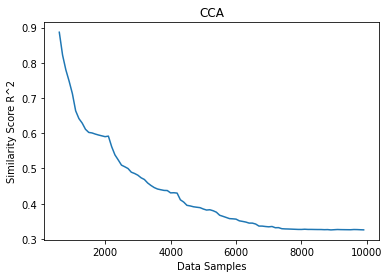

In [16]:
plt.plot(samples, cca_scores)
plt.title("CCA")
plt.ylabel("Similarity Score R^2")
plt.xlabel("Data Samples");

#### Randomized 

In [20]:
samples = np.arange(600, len(acts1), 100)
cca_scores= []
seed = np.random.randint(9999)
print(seed)
for s in samples:
    tf.random.set_seed(seed)
    sf_acts1 = tf.random.shuffle(acts1)
    tf.random.set_seed(seed)
    sf_acts2 = tf.random.shuffle(acts2)
    score = cca(acts1[:s], acts2[:s])
    cca_scores.append(score)
    

966


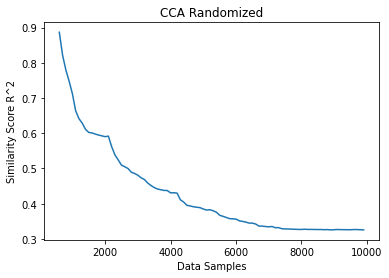

In [22]:
plt.plot(samples, cca_scores)
plt.title("CCA Randomized")
plt.ylabel("Similarity Score R^2")
plt.xlabel("Data Samples");

### CKA Linear

In [17]:
# CKA score
cka(linear_kernel(acts1), linear_kernel(acts2))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8588106>

In [24]:
samples = np.arange(600, len(acts1), 100)
cka_scores= []
for s in samples:
    score = cka(linear_kernel(acts1[:s]), linear_kernel(acts2[:s]))
    cka_scores.append(score)

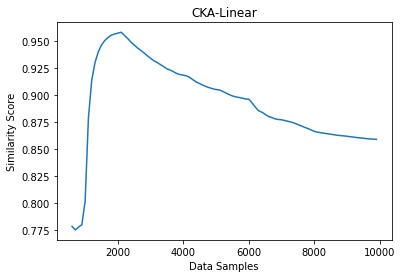

In [25]:
plt.plot(samples, cka_scores)
plt.title("CKA-Linear")
plt.ylabel("Similarity Score")
plt.xlabel("Data Samples");

#### Randomized

It is unclear what the impact of sample selection has on the CKA score.

In [274]:
# test = tf.constant(np.linspace((1,2),(10,20), 10))
# test2 = tf.constant(np.linspace((1,2),(10,20), 10))
# display(test)
# display(test2)

In [275]:
# tf.random.set_seed(0)
# tf.random.shuffle(test)

In [276]:
# tf.random.set_seed(0)
# tf.random.shuffle(test2)

In [159]:
samples = np.arange(10,acts1.shape[1]//2, 25)
runs = 100
cka_run_scores = []
labels = []
for r in range(runs):
    cka_scores= []
    seed = np.random.randint(9999)
#     print(seed)
    for s in samples:
        tf.random.set_seed(seed)
        sf_acts1 = tf.random.shuffle(acts1)
        tf.random.set_seed(seed)
        sf_acts2 = tf.random.shuffle(acts2)
        score = cka(linear_kernel(sf_acts1[:s]), linear_kernel(sf_acts2[:s]))
        cka_scores.append(score.numpy())
    cka_run_scores.append(np.array(cka_scores).reshape(1, -1))
    labels.append(r)

In [160]:
all_runs = np.concatenate(cka_run_scores, axis=0)
mean = all_runs.mean(axis=0)
var = all_runs.var(axis=0)
std = all_runs.std(axis=0)

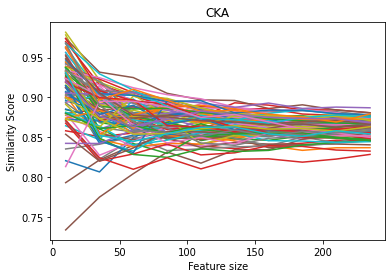

In [161]:
for s in cka_run_scores:
    plt.plot(samples, s.reshape(-1))
# plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("CKA")
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

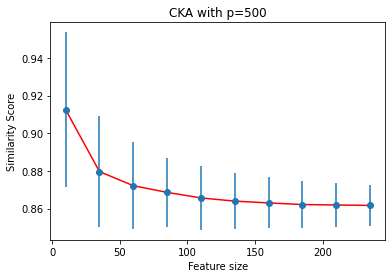

In [162]:
plt.plot(samples, mean, 'r')
# plt.fill_between(samples, mean-std, mean+std)
plt.errorbar(samples, mean, std, linestyle='None', marker='o')
plt.title("CKA with p={}".format(acts1.shape[1]))
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

In [ ]:
samples = np.arange(600, len(acts1), 100)
runs = 10
cka_run_scores = []
labels = []
for r in range(runs):
    cka_scores= []
    seed = np.random.randint(9999)
    print(seed)
    for s in samples:
        tf.random.set_seed(seed)
        sf_acts1 = tf.random.shuffle(acts1)
        tf.random.set_seed(seed)
        sf_acts2 = tf.random.shuffle(acts2)
        score = cka(linear_kernel(sf_acts1[:s]), linear_kernel(sf_acts2[:s]))
        cka_scores.append(score)
    cka_run_scores.append(cka_scores)
    labels.append(r)

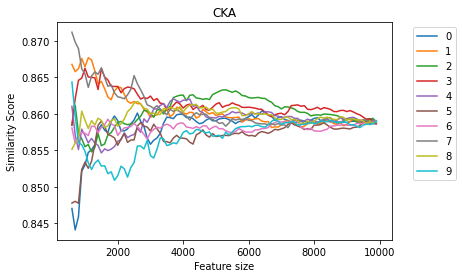

In [23]:
for s in cka_run_scores:
    plt.plot(samples, s)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("CKA")
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

In [351]:
# CKA score
tf.random.set_seed(seed)
sf_acts1 = tf.random.shuffle(acts1)
tf.random.set_seed(seed)
sf_acts2 = tf.random.shuffle(acts2)
cka(linear_kernel(sf_acts1), linear_kernel(sf_acts2))

<tf.Tensor: shape=(), dtype=float32, numpy=0.85881054>

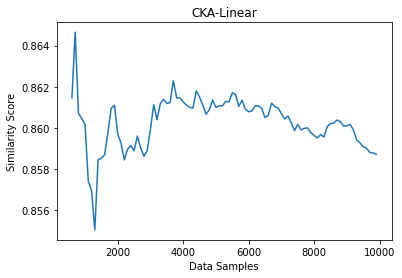

In [352]:
plt.plot(samples, cka_scores)
plt.title("CKA-Linear")
plt.ylabel("Similarity Score")
plt.xlabel("Data Samples");

### RBF

In [27]:
samples = np.arange(600, len(acts1), 100)
cka_rbf_scores= []
for s in samples:
    score = cka(rbf_kernel(acts1[:s]), rbf_kernel(acts2[:s]))
    cka_rbf_scores.append(score)

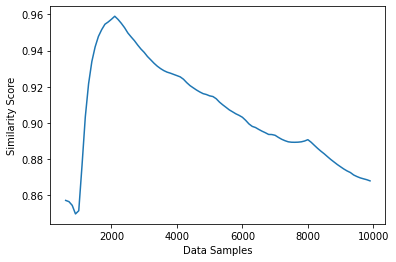

In [28]:
plt.plot(samples, cka_rbf_scores)
plt.title("CKA-RBF")
plt.ylabel("Similarity Score")
plt.xlabel("Data Samples");

### Compare All

In [210]:
def cka_compare_all(X_layers, Y_layers):
    layer_scores = np.zeros([len(X_layers), len(Y_layers)])
    X_iter = np.arange(len(X_layers),)[::-1]
    Y_iter = np.arange(len(Y_layers))
    for X, i in zip(X_layers, X_iter):
        scores = []
        for Y, j in zip(Y_layers, Y_iter):
            score = cka(linear_kernel(X), linear_kernel(Y))
            layer_scores[i, j] = score.numpy()
    return layer_scores


def plot_network_similarity(layer_scores, layer1_names, layer2_names):
    fig, ax = plt.subplots()
    im = ax.imshow(layer_scores)

    ax.set_xticks(np.arange(len(layer1_names)))
    ax.set_yticks(np.arange(len(layer2_names)))

    ax.set_xticklabels(layer1_names)
    ax.set_yticklabels(layer2_names[::-1])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(models[1])):
        for j in range(len(models[0])):
            text = ax.text(j, i, np.round(layer_scores[i, j], 2), ha="center", va="center", color="w")

    cbar = ax.figure.colorbar(im, ax=ax,)

    ax.set_title("CKA")
    fig.tight_layout()
    
    return fig, ax

In [ ]:
layer_scores = cka_compare_all(X_layers= models[0], Y_layers= models[1])

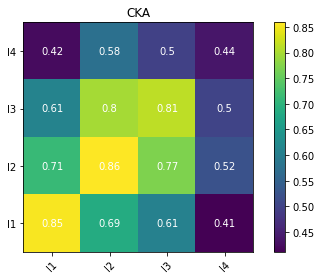

In [184]:
layer_names = ['l1', 'l2', 'l3', 'l4']
fig, ax = plot_network_similarity(layer_scores, layer_names, layer_names)
plt.show()

# CKA for Conv Nets with SVHN
SVHN consists of images that are 32 x 32 (height 32, width 32).Architecture looks like:

conv1(3x3,32 channels)-->maxpool(2x2)-->**conv2(3x3,64 channels)-->maxpool(2x2)-->batchnorm-->fc(200)**-->fc(10)

**ONLY LAYERS 3-6 are saved**

In [174]:
# Load up second hidden layer of MNIST networks and compare
model_file = "model_activations/SVHN/model_{}_lay0{}.p"
n_layers = np.arange(3, 6+1)
models = []
for m in range(2):
    layers = []
    for l in n_layers:
        with gzip.open(model_file.format(m, l), "rb") as f:
            print(model_file.format(m, l))
            layer = tf.constant(pickle.load(f), dtype=tf.float32)
            print(layer.shape)
        layers.append(layer)
    models.append(layers)

model_activations/SVHN/model_0_lay03.p
(1000, 16, 16, 64)
model_activations/SVHN/model_0_lay04.p
(1000, 8, 8, 64)
model_activations/SVHN/model_0_lay05.p
(1000, 4096)
model_activations/SVHN/model_0_lay06.p
(1000, 200)
model_activations/SVHN/model_1_lay03.p
(1000, 16, 16, 64)
model_activations/SVHN/model_1_lay04.p
(1000, 8, 8, 64)
model_activations/SVHN/model_1_lay05.p
(1000, 4096)
model_activations/SVHN/model_1_lay06.p
(1000, 200)


In [175]:
models_avg = []
for m in models:
    layers = []
    for l in m:
        if len(l.shape) > 2:
            l = tf.reduce_mean(l, axis=(1,2))
        print(l.shape)
        layers.append(l)
    models_avg.append(layers)
models = models_avg

(1000, 64)
(1000, 64)
(1000, 4096)
(1000, 200)
(1000, 64)
(1000, 64)
(1000, 4096)
(1000, 200)


In [182]:
acts1 = models[0][1]
acts2 = models[1][1]
# n x p
print("activation shapes", acts1.shape, acts2.shape)    

activation shapes (1000, 64) (1000, 64)


In [177]:
@timing
def run_cka():
    return cka(linear_kernel(acts1), linear_kernel(acts2))

run_cka()

run_cka function took 0.012 s


<tf.Tensor: shape=(), dtype=float32, numpy=0.957586>

### CCA

In [62]:
samples = np.arange(100, len(acts1), 50)
cca_scores= []
for s in samples:
    cca_scores.append(cca(acts1[:s], acts2[:s]))

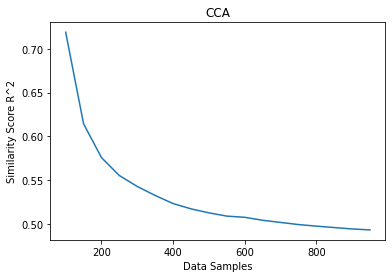

In [63]:
plt.plot(samples, cca_scores)
plt.title("CCA")
plt.ylabel("Similarity Score R^2")
plt.xlabel("Data Samples");

#### Randomized

In [66]:
samples = np.arange(100, len(acts1), 50)
cca_scores= []
seed = np.random.randint(9999)
print(seed)
for s in samples:
    tf.random.set_seed(seed)
    sf_acts1 = tf.random.shuffle(acts1)
    tf.random.set_seed(seed)
    sf_acts2 = tf.random.shuffle(acts2)
    score = cca(acts1[:s], acts2[:s])
    cca_scores.append(score)


8508


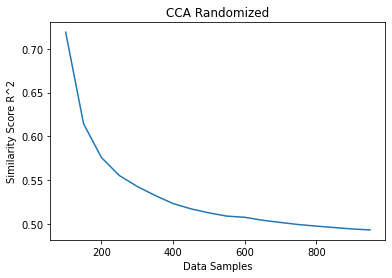

In [67]:
plt.plot(samples, cca_scores)
plt.title("CCA Randomized")
plt.ylabel("Similarity Score R^2")
plt.xlabel("Data Samples");

### CKA Linear

In [49]:
# CKA Score
cka(linear_kernel(acts1), linear_kernel(acts2))

<tf.Tensor: shape=(), dtype=float32, numpy=0.92414397>

In [50]:
samples = np.arange(100, len(acts1), 50)
cka_scores= []
for s in samples:
    score = cka(linear_kernel(acts1[:s]), linear_kernel(acts2[:s]))
    cka_scores.append(score)

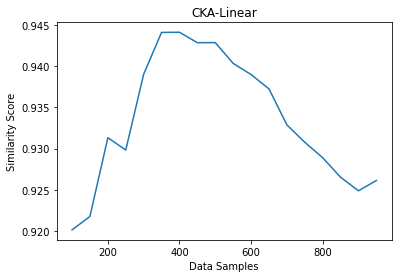

In [51]:
plt.plot(samples, cka_scores)
plt.title("CKA-Linear")
plt.ylabel("Similarity Score")
plt.xlabel("Data Samples");

#### Randomized

- If you select $n$ data samples and then shuffle the plot will be the same as above.
- However, if you shuffle and then sample $n$ data samples the plot is different, though convergence seems to be similar.

In [188]:
samples = np.arange(acts1.shape[1]*(8//128),acts1.shape[1]*2, 10)
runs = 100
cka_run_scores = []
labels = []
for r in range(runs):
    cka_scores= []
    seed = np.random.randint(9999)
#     print(seed)
    for s in samples:
        tf.random.set_seed(seed)
        sf_acts1 = tf.random.shuffle(acts1)
        tf.random.set_seed(seed)
        sf_acts2 = tf.random.shuffle(acts2)
        score = cka(linear_kernel(sf_acts1[:s]), linear_kernel(sf_acts2[:s]))
        cka_scores.append(score.numpy())
    cka_run_scores.append(np.array(cka_scores).reshape(1, -1))
    labels.append(r)

In [189]:
all_runs = np.concatenate(cka_run_scores, axis=0)
mean = all_runs.mean(axis=0)
var = all_runs.var(axis=0)
std = all_runs.std(axis=0)

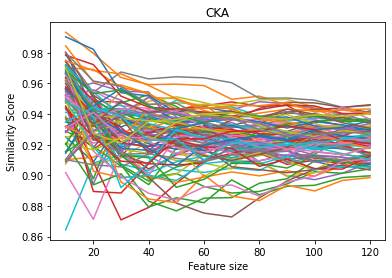

In [190]:
for s in cka_run_scores:
    plt.plot(samples, s.reshape(-1))
# plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("CKA")
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

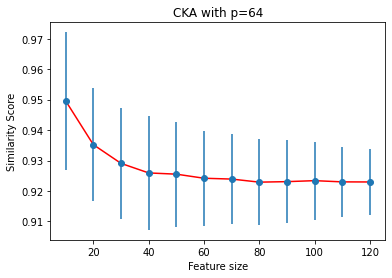

In [191]:
plt.plot(samples, mean, 'r')
# plt.fill_between(samples, mean-std, mean+std)
plt.errorbar(samples, mean, std, linestyle='None', marker='o')
plt.title("CKA with p={}".format(acts1.shape[1]))
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

In [192]:
samples = np.arange(100, len(acts1), 50)
runs = 10
cka_run_scores = []
labels = []
for r in range(runs):
    cka_scores= []
    seed = np.random.randint(9999)
    print(seed)
    for s in samples:
        tf.random.set_seed(seed)
        sf_acts1 = tf.random.shuffle(acts1)
        tf.random.set_seed(seed)
        sf_acts2 = tf.random.shuffle(acts2)
        score = cka(linear_kernel(sf_acts1[:s]), linear_kernel(sf_acts2[:s]))
        cka_scores.append(score)
    cka_run_scores.append(cka_scores)
    labels.append(r)

8587
2672
2390
4698
4442
4114
4640
6956
6090
9041


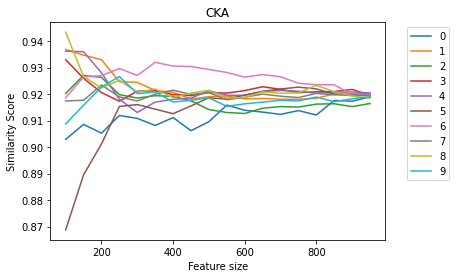

In [193]:
for s in cka_run_scores:
    plt.plot(samples, s)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("CKA")
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

In [396]:
cka_scores= []
for s in samples:
    tf.random.set_seed(seed)
    sf_acts1 = tf.random.shuffle(acts1)
    tf.random.set_seed(seed)
    sf_acts2 = tf.random.shuffle(acts2)
    score = cka(linear_kernel(sf_acts1[:s]), linear_kernel(sf_acts2[:s]))
    cka_scores.append(score)

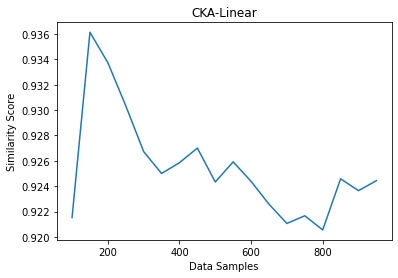

In [397]:
plt.plot(samples, cka_scores)
plt.title("CKA-Linear")
plt.ylabel("Similarity Score")
plt.xlabel("Data Samples");

In [398]:
tf.random.set_seed(seed)
sf_acts1 = tf.random.shuffle(acts1)
tf.random.set_seed(seed)
sf_acts2 = tf.random.shuffle(acts2)
# Random CKA score
cka(linear_kernel(sf_acts1), linear_kernel(sf_acts2))

<tf.Tensor: shape=(), dtype=float32, numpy=0.92414397>

### CKA RBF

In [94]:
samples = np.arange(100, len(acts1), 50)
cka_scores= []
for s in samples:
    score = cka(rbf_kernel(Acts1[:s]), rbf_kernel(acts2[:s]))
    cka_scores.append(score)

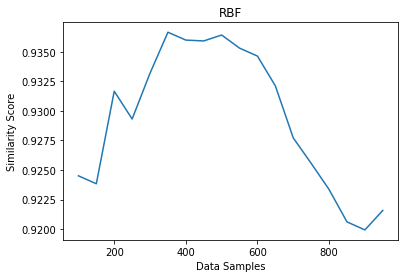

In [96]:
plt.plot(samples, cka_scores)
plt.title("CKA-RBF")
plt.ylabel("Similarity Score")
plt.xlabel("Data Samples");

### Compare All

In [206]:
layer_scores = cka_compare_all(X_layers= models[0], Y_layers= models[1])

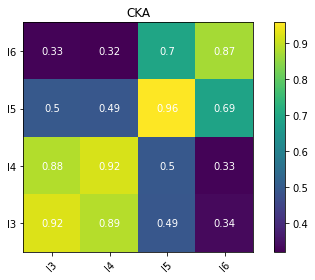

In [209]:
layer_scores = cka_compare_all(X_layers= models[0], Y_layers= models[1])
layer_names = ['l3', 'l4', 'l5', 'l6']
fig, ax = plot_network_similarity(layer_scores, layer_names, layer_names)
plt.show()

# How many samples are needed?

Adding more samples converges towards "less similarity"

## Test Unrelated Data

(array([55., 28., 16., 11.,  5.,  3.,  9.,  0.,  0.,  1.]),
 array([0.00797396, 0.56307125, 1.11816854, 1.67326583, 2.22836311,
        2.7834604 , 3.33855769, 3.89365498, 4.44875226, 5.00384955,
        5.55894684]),
 <BarContainer object of 10 artists>)

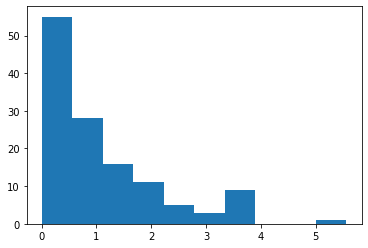

In [154]:
plt.hist(np.random.exponential(size=(128)))

(array([17., 12., 16.,  9., 16., 15., 13.,  9., 10., 11.]),
 array([0.01316455, 0.11136623, 0.2095679 , 0.30776958, 0.40597125,
        0.50417293, 0.60237461, 0.70057628, 0.79877796, 0.89697963,
        0.99518131]),
 <BarContainer object of 10 artists>)

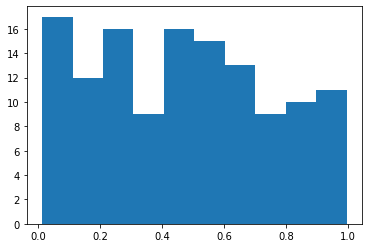

In [155]:
plt.hist(np.random.rand(128))

In [170]:
np.random.seed(42)
p = 128 # features 1
q = p  # features 2
n = p*5 # max samples
runs = 10
samples = np.arange(8, n, 10)
kernel = linear_kernel

cka_run_scores = []
labels = []
for r in range(runs):
    cka_scores= []

    for s in samples:
        X = tf.constant(np.random.randn(s, p))
#         X = tf.constant(np.random.exponential(size=(s, p)))
        Y = tf.constant(np.random.randn(s, q))

    
#         print("{}/{}".format(s,len(X)))
        score = cka(kernel(X), kernel(Y))
        cka_scores.append(score.numpy())
    cka_run_scores.append(np.array(cka_scores).reshape(1, -1))
    labels.append(r)

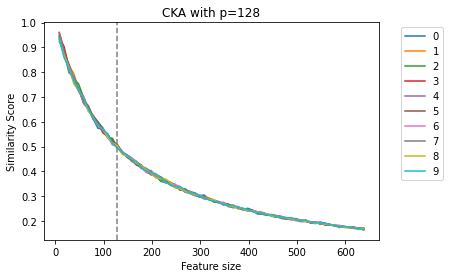

In [171]:
for s in cka_run_scores:
    plt.plot(samples, s.reshape(-1,))
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(x=p, color = 'gray', linestyle = '--') 
plt.title("CKA with p={}".format(p))
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

In [172]:
all_runs = np.concatenate(cka_run_scores, axis=0)
mean = all_runs.mean(axis=0)
var = all_runs.var(axis=0)
std = all_runs.std(axis=0)

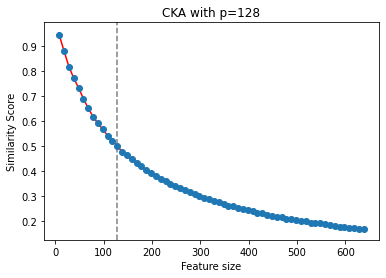

In [173]:
plt.plot(samples, mean, 'r')
# plt.fill_between(samples, mean-std, mean+std)
plt.errorbar(samples, mean, std, linestyle='None', marker='o')
plt.axvline(x=p, color = 'gray', linestyle = '--') 
plt.title("CKA with p={}".format(p))
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()

# Effect of features?

Adding more samples converges towards "more similarity"

In [130]:
np.random.seed(1332)
n = 1000
max_features = 1000
runs = 10
p_range = np.arange(1, max_features, 50)
kernel = linear_kernel

cka_run_scores = []
labels = []
for r in range(runs):
    cka_scores= []
    for p in p_range:
        q = p # Number of neuron activations
        X = tf.constant(np.random.randn(n, p), dtype=tf.float32)
        Y = tf.constant(np.random.randn(n, q) + X, dtype=tf.float32)

        score = cka(kernel(X), kernel(Y))
        cka_scores.append(score.numpy())
    cka_run_scores.append(cka_scores)
    labels.append(r)

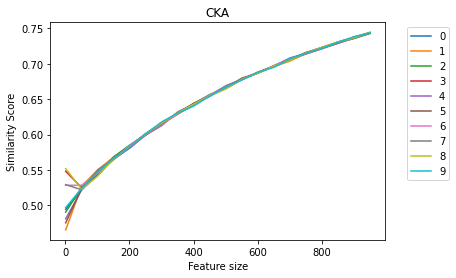

In [131]:
for s in cka_run_scores:
    plt.plot(p_range, s)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("CKA")
plt.ylabel("Similarity Score")
plt.xlabel("Feature size")
plt.show()